In [ ]:
#####################################################
#                                                   #
#                                                   #
#     Run in order skip the grid search boxes       #
#                                                   #
#                                                   #
#####################################################

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import sklearn
import warnings
random.seed(42)

Contest Functions

In [ ]:
def LoadInData(Path):
  return pd.read_excel(Path)

In [ ]:
def CleanDataSimple(DataSet):
  DataSet = DataSet.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
  Targets = DataSet["Comb Unrd Adj FE - Conventional Fuel"].astype(int)
  Dataset = DataSet[['Model Year','Index (Model Type Index)','# Cyl','Eng Displ','Transmission','Intake Valves Per Cyl','Exhaust Valves Per Cyl', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']]
  Dataset[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']] = Dataset[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']].astype(str)
  Dataset[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']] .fillna(0)
  Features = Dataset.columns
  return Dataset, Targets, Features

In [ ]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

In [ ]:
#Load in data files
Data2015 = LoadInData('./2015.xlsx')
Data2016 = LoadInData('./2016.xlsx')
Data2017 = LoadInData('./2017.xlsx')
Data2018 = LoadInData('./2018.xlsx');

In [ ]:
#Combine 2015 , 2016, 2017 into one large dataframe
Large151617 = pd.concat([Data2015, Data2016, Data2017], axis=0)
#Drop the columns that have NAN values(For Now)
Large151617 = Large151617.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
#Extract Targets
Targets = Large151617["Comb Unrd Adj FE - Conventional Fuel"]
#Extract Features
Features = Large151617.columns;
print(Features)
Simplified = Large151617[['Index (Model Type Index)','# Cyl','Eng Displ']]
Reduced = Large151617[['Model Year','Index (Model Type Index)','# Cyl','Eng Displ','Transmission','Intake Valves Per Cyl','Exhaust Valves Per Cyl', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']]


Index(['Model Year', 'Mfr Name', 'Division', 'Carline', 'Verify Mfr Cd',
       'Index (Model Type Index)', 'Eng Displ', '# Cyl', 'Transmission',
       'City FE (Guide) - Conventional Fuel',
       'Hwy FE (Guide) - Conventional Fuel',
       'Comb FE (Guide) - Conventional Fuel',
       'City Unadj FE - Conventional Fuel', 'Hwy Unadj FE - Conventional Fuel',
       'Comb Unadj FE - Conventional Fuel',
       'City Unrd Adj FE - Conventional Fuel',
       'Hwy Unrd Adj FE - Conventional Fuel',
       'Comb Unrd Adj FE - Conventional Fuel', 'Air Aspiration Method Desc',
       'Trans', 'Trans Desc', '# Gears', 'Lockup Torque Converter',
       'Trans Creeper Gear', 'Drive Sys', 'Drive Desc',
       'Fuel Usage  - Conventional Fuel',
       'Fuel Usage Desc - Conventional Fuel', 'Fuel Unit - Conventional Fuel',
       'Fuel Unit Desc - Conventional Fuel',
       'Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)',
       'Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA tr

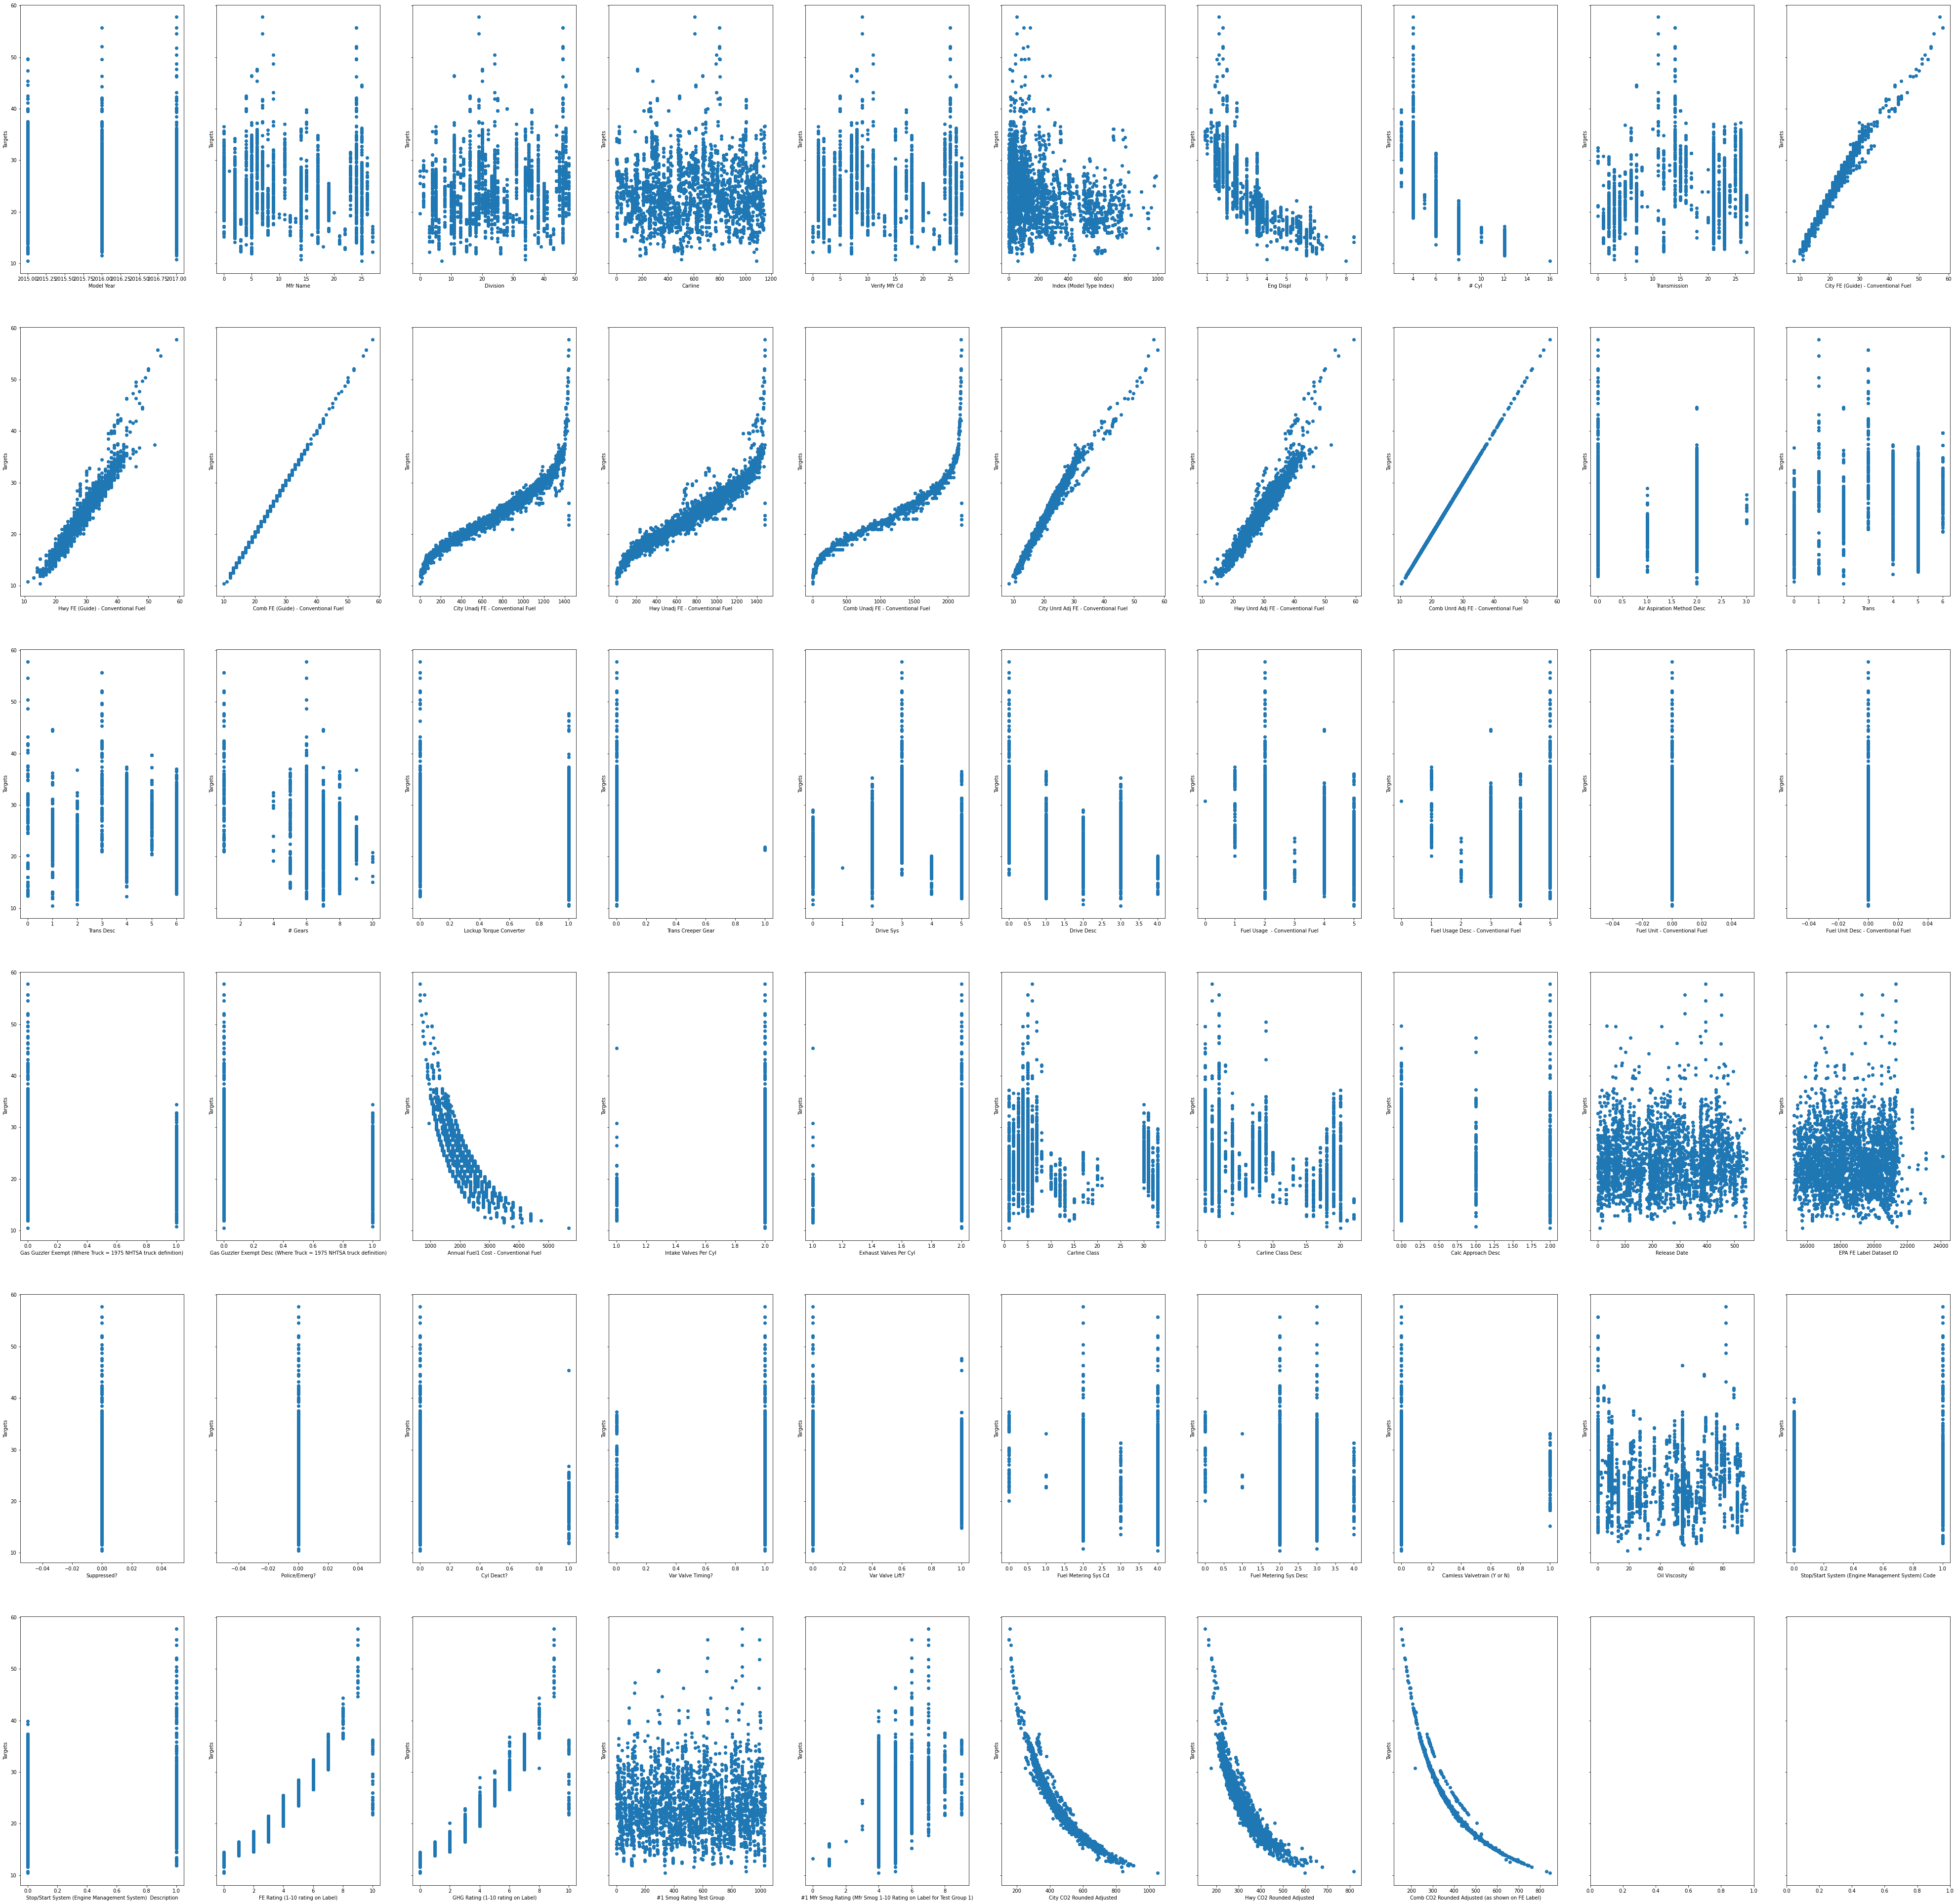

In [ ]:
#this does not have to be started !!
#Create a figure to see the features that are left after dropping NaN values
fig, ax = plt.subplots(6,10, sharey = True)
fig.set_size_inches(70,70)
counter = 0
for x in range(0,6):
    for y in range(0,10):
      if counter == 58:
        break
      elif Large151617[Features[counter]].dtype == 'object':
        New = Large151617[Features[counter]].astype('category').cat.codes
        ax[x][y].scatter(New, Targets)
        ax[x][y].set_ylabel('Targets')
        ax[x][y].set_xlabel(Features[counter])
        counter += 1
      elif (Large151617[Features[counter]]).dtype == 'int64' or "float64":
        ax[x][y].scatter(Large151617[Features[counter]], Targets)
        ax[x][y].set_ylabel('Targets')
        ax[x][y].set_xlabel(Features[counter])
        counter += 1
      else:
       print('NOOO')

In [ ]:
#!!!!!ONLY RUN THIS BLOCK FOR LINEAR REGRESSION MODEL
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Simplified, Targets, test_size=0.20, random_state=42)

In [ ]:

y_train_s.fillna(0)
y_test_s.fillna(0)
LR = LinearRegression()
LR.fit(X_train_s, y_train_s)
print("model score: %.3f" % LR.score(X_test_s, y_test_s))

model score: 0.615


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Reduced, Targets, test_size=0.20, random_state=42)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
numeric_features = ['Index (Model Type Index)','# Cyl','Eng Displ','Intake Valves Per Cyl','Exhaust Valves Per Cyl']
numeric_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures()),("scaler", StandardScaler())]
)

categorical_features = ['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']
categorical_transformer = Pipeline(steps=[('onehot' ,OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
X_train[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']] = X_train[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']].astype(str)
X_test[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']] = X_test[['Model Year','Transmission', 'Cyl Deact?','Camless Valvetrain (Y or N)','Drive Sys']].astype(str)
y_train.fillna(0)
y_test.fillna(0)

532     27.3161
678     31.5998
452     23.6312
787     21.4317
798     20.8386
         ...   
703     17.1295
596     19.1503
1225    17.9604
556     24.4122
296     19.3450
Name: Comb Unrd Adj FE - Conventional Fuel, Length: 742, dtype: float64

In [ ]:
##TAKES 10-20 MINS TO RUN

svm_C_val = np.logspace(-3, 3, 10)
svm_gamma_val = np.logspace(-3, 3, 10)

svm = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", svm.SVR())]
)


svm.fit(X_train, y_train)
print("model score: %.3f" % svm.score(X_test, y_test))

#GridSearch Best Alpha
svm_Param = {'classifier__C' : svm_gamma_val, 'classifier__gamma' : svm_gamma_val}
svmGrid = GridSearchCV(svm, param_grid=svm_Param , cv=5)
svmGrid.fit(X_train, y_train)
print("model score with best gamma and C: %.3f" % svmGrid.score(X_test, y_test))

model score: 0.785


KeyboardInterrupt: ignored

In [ ]:
#RUNS FAST
lasso_alpha_val = np.logspace(-3, 3, 20)

lasso = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", Lasso())]
)

#Default Param Model
lasso.fit(X_train, y_train)
print("model score: %.3f" % lasso.score(X_test, y_test))

#GridSearch Best Alpha
Lasso_Param = {'classifier__alpha' : lasso_alpha_val}
lassoGrid = GridSearchCV(lasso, param_grid=Lasso_Param , cv=10)
lassoGrid.fit(X_train, y_train)
print("model score with best alpha: %.3f" % lassoGrid.score(X_test, y_test))

model score: 0.591


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.698e+03, tolerance: 8.914e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.865e+03, tolerance: 8.769e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

model score with best alpha: 0.772


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.311e+03, tolerance: 9.802e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
#RUNS FAST
ridge_alpha_vals = np.logspace(-3, 3, 20)

ridge = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", Ridge())]
)

#Default Param Model
ridge.fit(X_train, y_train)
print("model score: %.3f" % ridge.score(X_test, y_test))

#GridSearch Best Alpha
Ridge_Param = {'classifier__alpha' : ridge_alpha_vals}
ridgeGrid = GridSearchCV(ridge, param_grid=Ridge_Param , cv=10)
ridgeGrid.fit(X_train, y_train)
print("model score with best alpha: %.3f" % ridgeGrid.score(X_test, y_test))

model score: 0.773
model score with best alpha: 0.773


In [ ]:
#RUNS FAST
Elasticnet = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", ElasticNet())]
)
Elasticnet.fit(X_train, y_train)
print("model score: %.3f" % Elasticnet.score(X_test, y_test))

model score: 0.603


In [ ]:
#RUNS FAST
GBR = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
)
GBRFIT = GBR.fit(X_train, y_train)
print("model score: %.3f" % GBR.score(X_test, y_test))

model score: 0.840


In [ ]:
#RUNS SLOW 1-2 HOURS
parameters = {'classifier__learning_rate': [0.01,0.02,0.03,0.04],
                  'classifier__subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'classifier__n_estimators' : [100,500,1000, 1500],
                  'classifier__max_depth'    : [4,6,8,10]
                 }
gridGBR = GridSearchCV(GBR, param_grid = parameters)
gridGBR.fit(X_train,y_train)
print(gridGBR.score(X_test,y_test))

KeyboardInterrupt: ignored

In [ ]:
#GRID SEARCH BEST PARAMETERS
GBRBestparam = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor(learning_rate=0.01, max_depth= 10, n_estimators= 500, subsample= 0.5))]
)
GBRBestparam.fit(X_train,y_train)
featurenames2 = get_feature_names(preprocessor)
#featurenames = GBRBestparam.named_steps['preprocessor'].transformers_[1][0]\
#   .named_steps['onehot'].get_feature_names_out(categorical_features)
print(GBRBestparam.score(X_test,y_test))

61
0.9063673990715438


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [ ]:
#RUNS FAST
from pickle import NONE
from sklearn.ensemble import RandomForestRegressor
DFT = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor())])
DFT.fit(X_train, y_train)
print(DFT.score(X_test, y_test))


0.9057223132578643


In [ ]:
#RUNS SLOW 30-HOUR
parameters = {'classifier__n_estimators' : [50,100,200,300,500],
            'classifier__max_features' : [None, 1,.5,2,4,.25, "sqrt", "log2"],
          'classifier__max_depth' : [None,1,2,3,4]}


gridDFT = GridSearchCV(DFT, param_grid=parameters)
gridDFT.fit(X_train,y_train)
print(gridDFT.score(X_test,y_test))

0.906722213733163


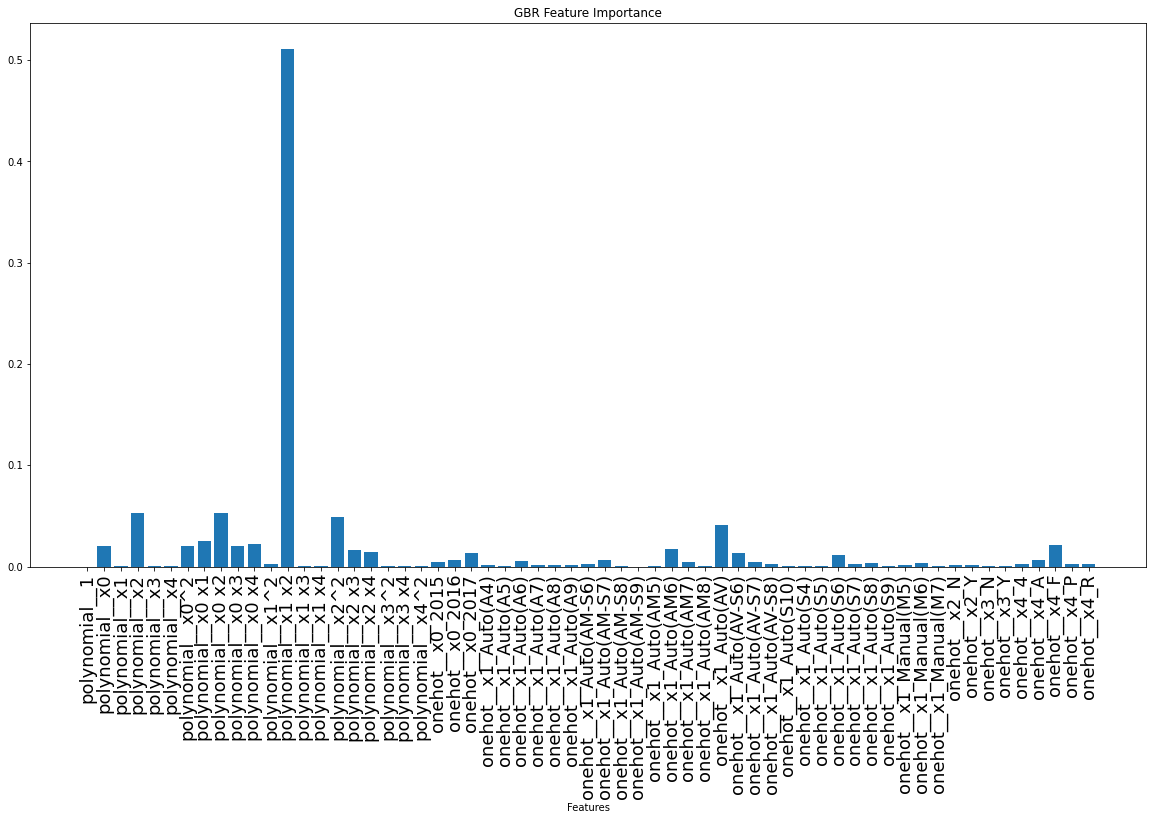

In [ ]:
#Removing features did not relly effect my model R^2 went up a less then a percent


fig, ax = plt.subplots(figsize=(20, 10))
#ax.figure(figsize=(100, 75))

ax.bar(range(len(GBRBestparam[1].feature_importances_)), GBRBestparam[1].feature_importances_)
ax.set_title('GBR Feature Importance')
ax.set_xlabel('Features')
ax.set_xticks(range(0,61))
ax.set_xticklabels(featurenames2, rotation='vertical', fontsize=18)

fig.show()


In [ ]:
from sklearn import tree
## SIMPLE MODEL EXPLAINABLE MODEL 5% OFF R^2
DTR = Pipeline(steps=[("classifier", tree.DecisionTreeRegressor())])
DTR.fit(X_train_s, y_train_s)
print(DTR.score(X_test_s, y_test_s))
text_representation = tree.export_text(DTR[0])
print(text_representation)

0.6342524557981696
|--- feature_2 <= 2.60
|   |--- feature_2 <= 1.90
|   |   |--- feature_2 <= 1.35
|   |   |   |--- feature_2 <= 1.10
|   |   |   |   |--- feature_0 <= 233.50
|   |   |   |   |   |--- feature_0 <= 47.50
|   |   |   |   |   |   |--- value: [35.65]
|   |   |   |   |   |--- feature_0 >  47.50
|   |   |   |   |   |   |--- feature_0 <= 70.50
|   |   |   |   |   |   |   |--- feature_0 <= 51.50
|   |   |   |   |   |   |   |   |--- value: [34.75]
|   |   |   |   |   |   |   |--- feature_0 >  51.50
|   |   |   |   |   |   |   |   |--- value: [34.89]
|   |   |   |   |   |   |--- feature_0 >  70.50
|   |   |   |   |   |   |   |--- feature_0 <= 159.50
|   |   |   |   |   |   |   |   |--- value: [35.65]
|   |   |   |   |   |   |   |--- feature_0 >  159.50
|   |   |   |   |   |   |   |   |--- value: [34.84]
|   |   |   |   |--- feature_0 >  233.50
|   |   |   |   |   |--- feature_0 <= 269.50
|   |   |   |   |   |   |--- feature_0 <= 251.50
|   |   |   |   |   |   |   |--- value: [31

In [ ]:
##TESTING TO SEE IF I CAN MAKE IT LESS SIMPLE MORE EFFECTIVE
parameters={"classifier__splitter":["best","random"],
           "classifier__min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "classifier__max_features":["auto","log2","sqrt",None],
           "classifier__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}
DTRG = Pipeline(steps=[('preprocessor', preprocessor),("classifier", tree.DecisionTreeRegressor())])
gridDTR = GridSearchCV(DTRG, param_grid=parameters)
gridDTR.fit(X_train,y_train)
print(gridDTR.score(X_test,y_test))

0.8636737722764615
